# HPRD
 
Experimentos utilizando a rede [Human Protein Reference Database](https://www.ndexbio.org/viewer/networks/1093e665-86da-11e7-a10d-0ac135e8bacf?accesskey=7fbd23635b798321954e66c63526c46397a3f45b40298cf43f22d07d4feed0fa)

## debugging


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mygene
import h5py
import pickle
import argparse
import networkx as nx
import seaborn as sns
%matplotlib inline

In [2]:
import os, sys

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)

from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE
from stellargraph.utils import plot_history

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score
from IPython.display import display, HTML

import tensorflow as tf
from scipy.sparse import csr_matrix, lil_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense

In [3]:
network = pd.read_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/data_final_v2/HPRD_network.tsv', sep='\t')

features = pd.read_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/data_final_v2/HPRD_features_complete.tsv', sep='\t', index_col='gene')

labels = pd.read_csv('C:/Users/renan/Desktop/UFRGS/GNN/data/data_final_v2/HPRD_labels_semisupervised.tsv', sep='\t', index_col='gene')

In [4]:
# Transformar as labels boleanas em 0/1 para aplicar no preprocessing.OrdinalEncoder
labels["label"].replace({False: 0, True: 1}, inplace=True)

# Transformar as labels vazias em -1
labels["label"] = labels.label.fillna(-1)

In [5]:
G = StellarGraph(edges=network, nodes=features)

print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 9438, Edges: 36844

 Node types:
  default: [9438]
    Features: float32 vector, length 68
    Edge types: default-default->default

 Edge types:
    default-default->default: [36844]
        Weights: all 1 (default)
        Features: none


In [6]:
series_classes = labels['label']

series_classes.value_counts(dropna = False).to_frame()

,label
0.0,4873
-1.0,3772
1.0,793


In [7]:
# Dividindo dados em treino/validação/teste

train_ratio = 0.80
test_ratio = 0.20

labeled_data = labels[labels['label'] != -1]
labeled_data = labeled_data.sample(frac=1)

# Aqui aplica-se então 20% do tamanho total da rede e o restante para treino
labeled_train, labeled_test = model_selection.train_test_split(
    labeled_data, test_size=test_ratio, stratify=labeled_data)


print("Train: ", len(labeled_train))
print("Test: ", len(labeled_test))
print("\nTotal: ", len(labeled_train)+len(labeled_test))

Train:  4532
Test:  1134

Total:  5666


In [8]:
# Difinição da função de custo Focal Loss

import dill

from keras import backend as K

def binary_focal_loss(gamma=2., alpha=.25):

    def binary_focal_loss_fixed(y_true, y_pred):
     
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return binary_focal_loss_fixed

In [9]:
def dyn_weighted_bincrossentropy(true, pred):
    """
    Calculates weighted binary cross entropy. The weights are determined dynamically
    by the balance of each category. This weight is calculated for each batch.
    
    The weights are calculted by determining the number of 'pos' and 'neg' classes 
    in the true labels, then dividing by the number of total predictions.
    
    For example if there is 1 pos class, and 99 neg class, then the weights are 1/100 and 99/100.
    These weights can be applied so false negatives are weighted 99/100, while false postives are weighted
    1/100. This prevents the classifier from labeling everything negative and getting 99% accuracy.
    
    This can be useful for unbalanced catagories.
    """
    true = tf.cast(true, tf.float32)
    pred = tf.cast(pred, tf.float32)

    # get the total number of inputs
    num_pred = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) + keras.backend.sum(true)
    
    # get weight of values in 'pos' category
    zero_weight =  keras.backend.sum(true)/ num_pred +  keras.backend.epsilon() 
    
    # get weight of values in 'false' category
    one_weight = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) / num_pred +  keras.backend.epsilon()

    # calculate the weight vector
    weights =  (1.0 - true) * zero_weight +  true * one_weight 
    
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)

In [10]:
import keras

def weighted_bincrossentropy(true, pred, weight_zero = 0.6, weight_one = 1):
    """
    Calculates weighted binary cross entropy. The weights are fixed.
        
    This can be useful for unbalanced catagories.
    
    Adjust the weights here depending on what is required.
    
    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives 
        will be penalize 10 times as much as false negatives.
    """
  
    true = tf.cast(true, tf.float32)
    pred = tf.cast(pred, tf.float32)

    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)

In [11]:
target_encoding = preprocessing.LabelBinarizer()

validation_ratio = 0.20
labeled_train_temp = labeled_train

train_temp, labeled_val = model_selection.train_test_split(
    labeled_train_temp, test_size=validation_ratio, stratify=labeled_train_temp)

train_targets = target_encoding.fit_transform(train_temp)
val_targets = target_encoding.transform(labeled_val)
test_targets = target_encoding.transform(labeled_test)

print("Train: ", len(train_temp))
print("Validation: ", len(labeled_val))

Train:  3625
Validation:  907


In [12]:
neg, pos = np.bincount(train_temp['label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 3625
    Positive: 507 (13.99% of total)


In [13]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_temp.index, train_targets)

In [14]:
gat = GAT(
    layer_sizes=[64, 64, train_targets.shape[1]], 
    activations=["ReLU", "ReLU", "sigmoid"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.01,
    attn_dropout=0.01,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()

In [15]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    #loss=weighted_bincrossentropy,
    #loss="binary_crossentropy",
    loss=[binary_focal_loss(gamma=2, alpha=0.75)],
    metrics=["acc", metrics.AUC(curve="ROC", name="auc_roc"), metrics.AUC(curve="PR", name="auc_pr")]
)

val_gen = generator.flow(labeled_val.index, val_targets)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
    
es_callback = EarlyStopping(
    monitor="val_auc_pr", patience=100 #500 #200
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_auc_pr", save_best_only=True, save_weights_only=True
)

In [17]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # manter em falso, uma vez que embaralhar os dados significa embaralhar todo o grafo
    #callbacks=[es_callback, mc_callback],
)

Epoch 1/100
1/1 - 12s - loss: 197.3258 - acc: 0.8262 - auc_roc: 0.4560 - auc_pr: 0.1187 - val_loss: 48.5464 - val_acc: 0.8567 - val_auc_roc: 0.5370 - val_auc_pr: 0.1387
Epoch 2/100
1/1 - 2s - loss: 194.4570 - acc: 0.8579 - auc_roc: 0.4824 - auc_pr: 0.1236 - val_loss: 47.9053 - val_acc: 0.8589 - val_auc_roc: 0.5396 - val_auc_pr: 0.1405
Epoch 3/100
1/1 - 2s - loss: 191.9189 - acc: 0.8596 - auc_roc: 0.4815 - auc_pr: 0.1247 - val_loss: 47.3646 - val_acc: 0.8600 - val_auc_roc: 0.5220 - val_auc_pr: 0.1338
Epoch 4/100
1/1 - 2s - loss: 189.7854 - acc: 0.8599 - auc_roc: 0.4844 - auc_pr: 0.1242 - val_loss: 46.9200 - val_acc: 0.8600 - val_auc_roc: 0.5390 - val_auc_pr: 0.1386
Epoch 5/100
1/1 - 2s - loss: 188.1066 - acc: 0.8601 - auc_roc: 0.5002 - auc_pr: 0.1282 - val_loss: 46.5685 - val_acc: 0.8600 - val_auc_roc: 0.5356 - val_auc_pr: 0.1375
Epoch 6/100
1/1 - 2s - loss: 186.6189 - acc: 0.8601 - auc_roc: 0.5014 - auc_pr: 0.1293 - val_loss: 46.3038 - val_acc: 0.8600 - val_auc_roc: 0.5383 - val_auc_pr

In [18]:
# Gerando um dataframe com as probabilidades na etapa de treinamento

nodes_train = train_temp.index
gen_train = generator.flow(nodes_train)
train_predictions = model.predict(gen_train)

train_predictions2 = target_encoding.inverse_transform(train_predictions.squeeze())

train_probs = pd.DataFrame({"Predicted": train_predictions2, "Probability": train_predictions.squeeze(), "True": train_temp['label']})

train_probs

,Predicted,Probability,True
gene,,,
OSR1,0.0,0.493197,0.0
TRMT61A,0.0,0.134137,0.0
PYDC2,0.0,0.290970,0.0
SS18L1,0.0,0.493209,1.0
FRMD6,0.0,0.435104,0.0
...,...,...,...
HDAC4,0.0,0.493361,1.0
GCG,0.0,0.321607,0.0
CBR1,0.0,0.414008,0.0


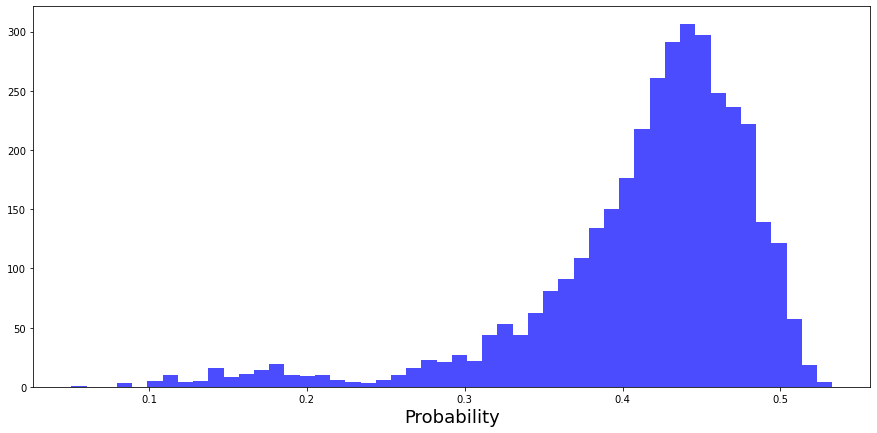

In [19]:
plt.figure(figsize=(15,7))
plt.hist(train_probs['Probability'], bins=50, alpha=0.7, color='b')
plt.xlabel('Probability', fontsize=18)
plt.show() 

In [20]:
# Gerando um dataframe com as probabilidades na etapa de validação

nodes_val = labeled_val.index
gen_val = generator.flow(nodes_val)
val_predictions = model.predict(gen_val)

val_predictions2 = target_encoding.inverse_transform(val_predictions.squeeze())

val_probs = pd.DataFrame({"Predicted": val_predictions2, "Probability": val_predictions.squeeze(), "True": labeled_val['label']})

val_probs

,Predicted,Probability,True
gene,,,
PMM1,0.0,0.377296,0.0
NUP205,0.0,0.213296,0.0
CIITA,0.0,0.494303,1.0
NCOR2,1.0,0.502197,1.0
ST7,0.0,0.426955,0.0
...,...,...,...
MFSD3,0.0,0.372364,0.0
SSR1,0.0,0.437768,0.0
INSC,0.0,0.443032,0.0


In [21]:
val_probs.describe()

,Predicted,Probability,True
count,907.000000,907.000000,907.000000
mean,0.022051,0.410945,0.140022
std,0.146930,0.077062,0.347201
min,0.000000,0.050838,0.000000
25%,0.000000,0.385726,0.000000
50%,0.000000,0.432144,0.000000
75%,0.000000,0.460403,0.000000
max,1.000000,0.535462,1.000000


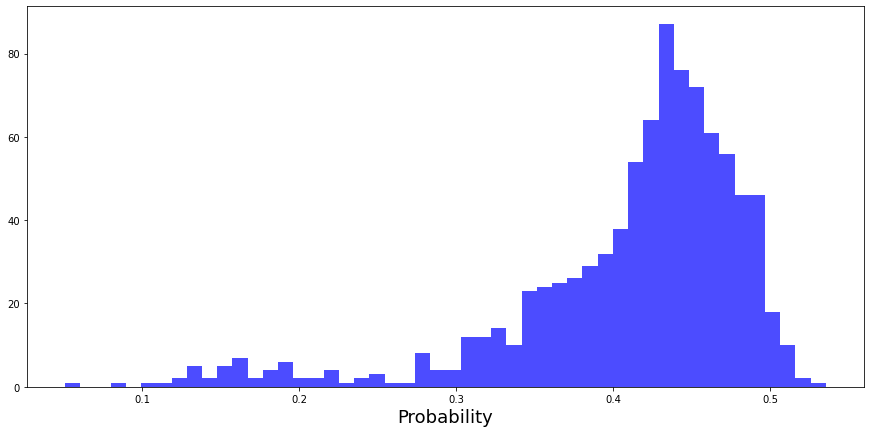

In [22]:
plt.figure(figsize=(15,7))
plt.hist(val_probs['Probability'], bins=50, alpha=0.7, color='b')
plt.xlabel('Probability', fontsize=18)
plt.show() 

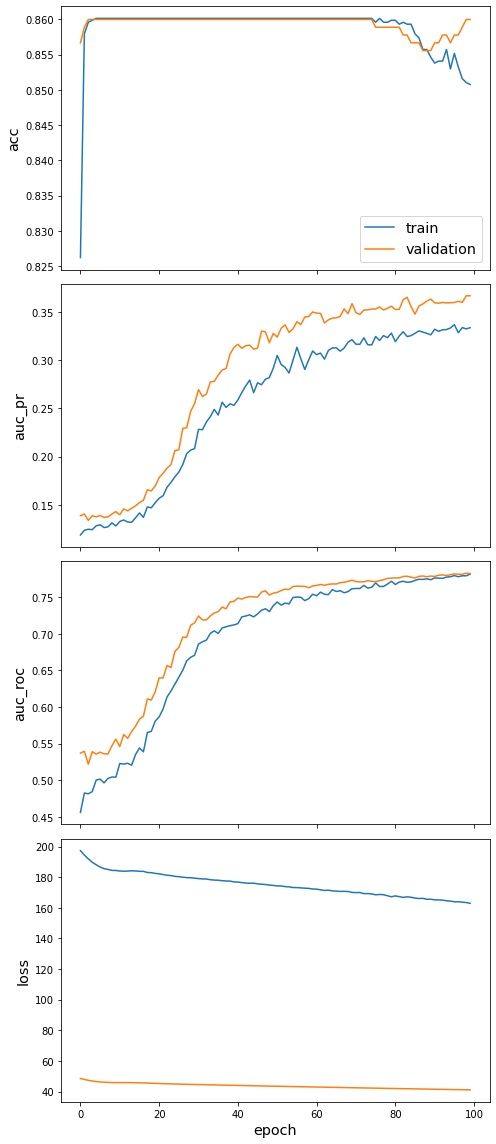

In [23]:
sg.utils.plot_history(history)

In [24]:
#model.load_weights("logs/best_model.h5")

test_gen = generator.flow(labeled_test.index, test_targets)
test_metrics = model.evaluate(test_gen)

print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 448ms/step - loss: 53.5072 - acc: 0.8571 - auc_roc: 0.7255 - auc_pr: 0.3234

Test Set Metrics:
	loss: 53.5072
	acc: 0.8571
	auc_roc: 0.7255
	auc_pr: 0.3234


In [25]:
all_nodes = series_classes.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

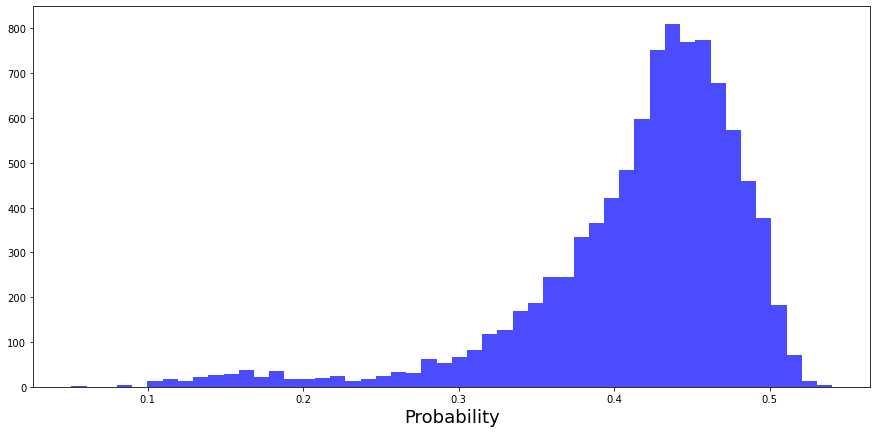

In [26]:
plt.figure(figsize=(15,7))
plt.hist(all_predictions.squeeze(), bins=50, alpha=0.7, color='b')
plt.xlabel('Probability', fontsize=18)
plt.show() 

In [27]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": series_classes})

#df.head(20)

print(df['True'].value_counts(), "\n")
df['Predicted'].value_counts()

 0.0    4873
-1.0    3772
 1.0     793
Name: True, dtype: int64 



0.0    9136
1.0     302
Name: Predicted, dtype: int64

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix(series_classes, node_predictions)

array([[   0, 3646,  126],
       [   0, 4767,  106],
       [   0,  723,   70]], dtype=int64)